In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys

sys.path.append("../..")
%matplotlib inline

In [2]:
from processor.preprocessors import data_split
from trading_env.env_cryptotrading_v1 import CryptoTradingEnv
from agent.models import DRLAgent
from config import (
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    VALID_2_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
)
from stable_baselines3.common.logger import configure

In [3]:
processed_dts10_add_tech = pd.read_csv("../../dataset/hour-level/crypto_TI_t10_2023-04-01.csv")

In [4]:
state_interval = 5
TEST_START_DATE = pd.to_datetime(TEST_START_DATE)
TEST_START_DATE = TEST_START_DATE - pd.Timedelta(hours=state_interval - 1)
TEST_START_DATE = TEST_START_DATE.strftime('%Y-%m-%d %H:%M:%S')

In [5]:
train = data_split(processed_dts10_add_tech, TRAIN_START_DATE, VALID_2_END_DATE)
valid = data_split(processed_dts10_add_tech, TEST_START_DATE, TEST_END_DATE)

print(len(train))
print(len(valid))


175190
21640


In [6]:
crypto_tic_dim = len(train.tic.unique())
# state_space_dim = 1 + 2*crypto_tic_dim + len(INDICATORS)*crypto_tic_dim
state_space_dim = 1 + (state_interval * 5 + 1) * crypto_tic_dim
print(f"Stock Dimension: {crypto_tic_dim}, State Space: {state_space_dim}")

Stock Dimension: 10, State Space: 261


## Agents

### PPO

In [7]:
buy_cost_list = sell_cost_list = [0.001] * crypto_tic_dim
num_stock_shares = [0] * crypto_tic_dim

env_kwargs_train = {
    "cash": 100000,
    "action_scaling": 1/10,
    "num_crypto_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space_dim": state_space_dim,
    "crypto_dim": crypto_tic_dim,
    "action_space_dim": crypto_tic_dim,
    "print_verbosity": 5,
    "eval_time_interval": 30 * 24,
    "is_debug": True,
    "risk_control": True,
    "model_name": "ppo_hour_level",
    "data_granularity": 24,
    "state_interval": state_interval
}
env_kwargs_test = env_kwargs_train.copy()
env_kwargs_test["is_debug"] = False

In [8]:
e_train_gym = CryptoTradingEnv(df = train, **env_kwargs_train)
e_valid_gym = CryptoTradingEnv(df = valid, **env_kwargs_test)

In [9]:
agent = DRLAgent(env = e_train_gym)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.001,
    "batch_size": 256
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS, seed=42)
# set up logger
tmp_path = RESULTS_DIR + '/ppo_hour_level'
new_logger_ppo = configure(tmp_path, ["csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.001, 'batch_size': 256}
Using cuda device


In [10]:
final = []
iterations = 30
max_account_value = 0

for i in range(iterations):
    # train model
    trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo', total_timesteps=100000)
    df_account_value_ppo, df_actionppo, df_valid_actionppo, df_stateppo = DRLAgent.DRL_prediction(model=trained_ppo, environment=e_valid_gym)
    res = df_account_value_ppo["portfolio_value"][len(df_account_value_ppo)-1]
    final.append(df_account_value_ppo["portfolio_value"])
    df_account_value_ppo.to_csv(f"../../plot/dataset/ppo_hourly_stack_frame/test/stack_5_round_{i + 1}_res_{res:.0f}_default_ppo_act_0.1_seed_42_new_reward.csv")
    trained_ppo.save(f"../../model_saves/ppo_hourly_stack_frame/test/stack_5_round_{i + 1}_res_{res:.0f}_default_ppo_act_0.1_seed_42_new_reward")


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 5
begin_portfolio_value:	 99986.23
end_portfolio_value:	 438.35
total_profits:		 -99547.88
total_buy_cost:		 190084.43
total_sell_cost:	 190364.88
total_buy_trades:	 46646
total_sell_trades:	 53544

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 10
begin_portfolio_value:	 99957.47
end_portfolio_value:	 1834.80
total_profits:		 -98122.67
total_buy_cost:		 382432.62
total_sell_cost:	 383098.23
total_buy_trades:	 42050
total_sell_trades:	 47640

episode:		 5
begin_portfolio_value:	 99990.44
end_portfolio_value:	 123922.31
total_profits:		 23931.87
total_buy_cost:		 17608.83
total_sell_cost:	 17543.99
total_buy_trades:	 3082
total_sell_trades:	 3722

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 15
begin_portfolio_value:	 99942.43
end_portfolio_value:	 866.13
total_profits:		 -99076.30
total_buy_cost:		 408560.63
total_sell_cost:	 409278.47
total_buy_trades:	 42597
total_sell_trades:	 47647

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 20
begin_portfolio_value:	 99950.98
end_portfolio_value:	 800.47
total_profits:		 -99150.51
total_buy_cost:		 301163.91
total_sell_cost:	 301666.77
total_buy_trades:	 39223
total_sell_trades:	 43210

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 30
begin_portfolio_value:	 99957.18
end_portfolio_value:	 1976.42
total_profits:		 -97980.75
total_buy_cost:		 166840.26
total_sell_cost:	 167074.56
total_buy_trades:	 30646
total_sell_trades:	 31958

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 35
begin_portfolio_value:	 99951.00
end_portfolio_value:	 1601.14
total_profits:		 -98349.86
total_buy_cost:		 266380.59
total_sell_cost:	 266813.78
total_buy_trades:	 29309
total_sell_trades:	 30099

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 40
begin_portfolio_value:	 99965.06
end_portfolio_value:	 1399.30
total_profits:		 -98565.76
total_buy_cost:		 277644.97
total_sell_cost:	 278100.71
total_buy_trades:	 31073
total_sell_trades:	 32139

episode:		 20
begin_portfolio_value:	 99971.60
end_portfolio_value:	 114528.46
total_profits:		 14556.86
total_buy_cost:		 15595.53
total_sell_cost:	 15526.66
total_buy_trades:	 2168
total_sell_trades:	 2390

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 45
begin_portfolio_value:	 99960.04
end_portfolio_value:	 1863.29
total_profits:		 -98096.75
total_buy_cost:		 249223.18
total_sell_cost:	 249622.57
total_buy_trades:	 29878
total_sell_trades:	 30593

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 50
begin_portfolio_value:	 99963.81
end_portfolio_value:	 1347.23
total_profits:		 -98616.58
total_buy_cost:		 208670.12
total_sell_cost:	 208987.99
total_buy_trades:	 30508
total_sell_trades:	 31361

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 60
begin_portfolio_value:	 99945.98
end_portfolio_value:	 1755.27
total_profits:		 -98190.70
total_buy_cost:		 203040.68
total_sell_cost:	 203347.44
total_buy_trades:	 29719
total_sell_trades:	 30064

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 65
begin_portfolio_value:	 99931.77
end_portfolio_value:	 2476.95
total_profits:		 -97454.81
total_buy_cost:		 393552.51
total_sell_cost:	 394240.30
total_buy_trades:	 32858
total_sell_trades:	 33757

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 70
begin_portfolio_value:	 99940.06
end_portfolio_value:	 1001.30
total_profits:		 -98938.76
total_buy_cost:		 270788.44
total_sell_cost:	 271230.46
total_buy_trades:	 36226
total_sell_trades:	 37646

episode:		 35
begin_portfolio_value:	 99950.50
end_portfolio_value:	 116100.23
total_profits:		 16149.72
total_buy_cost:		 13357.66
total_sell_cost:	 13284.31
total_buy_trades:	 1817
total_sell_trades:	 1872

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 75
begin_portfolio_value:	 99972.30
end_portfolio_value:	 606.12
total_profits:		 -99366.18
total_buy_cost:		 196073.68
total_sell_cost:	 196366.12
total_buy_trades:	 32568
total_sell_trades:	 33306

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 80
begin_portfolio_value:	 99940.17
end_portfolio_value:	 1008.55
total_profits:		 -98931.62
total_buy_cost:		 231955.69
total_sell_cost:	 232319.97
total_buy_trades:	 29884
total_sell_trades:	 30181

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 90
begin_portfolio_value:	 99946.45
end_portfolio_value:	 1039.92
total_profits:		 -98906.53
total_buy_cost:		 162597.12
total_sell_cost:	 162822.54
total_buy_trades:	 26315
total_sell_trades:	 25830

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 95
begin_portfolio_value:	 99930.07
end_portfolio_value:	 5176.92
total_profits:		 -94753.15
total_buy_cost:		 489563.47
total_sell_cost:	 490443.48
total_buy_trades:	 27327
total_sell_trades:	 26956

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 100
begin_portfolio_value:	 99938.12
end_portfolio_value:	 783.80
total_profits:		 -99154.31
total_buy_cost:		 162675.80
total_sell_cost:	 162901.38
total_buy_trades:	 29641
total_sell_trades:	 29706

episode:		 50
begin_portfolio_value:	 99955.78
end_portfolio_value:	 108772.91
total_profits:		 8817.14
total_buy_cost:		 11763.55
total_sell_cost:	 11687.00
total_buy_trades:	 1457
total_sell_trades:	 1412

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 105
begin_portfolio_value:	 99930.07
end_portfolio_value:	 1051.49
total_profits:		 -98878.58
total_buy_cost:		 196883.85
total_sell_cost:	 197177.92
total_buy_trades:	 30308
total_sell_trades:	 30358

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 110
begin_portfolio_value:	 99947.14
end_portfolio_value:	 691.38
total_profits:		 -99255.75
total_buy_cost:		 208564.56
total_sell_cost:	 208882.19
total_buy_trades:	 33659
total_sell_trades:	 34296

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 120
begin_portfolio_value:	 99960.04
end_portfolio_value:	 1474.48
total_profits:		 -98485.56
total_buy_cost:		 319920.98
total_sell_cost:	 320461.36
total_buy_trades:	 32852
total_sell_trades:	 33270

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 125
begin_portfolio_value:	 99956.43
end_portfolio_value:	 1164.22
total_profits:		 -98792.21
total_buy_cost:		 368382.02
total_sell_cost:	 369019.43
total_buy_trades:	 35884
total_sell_trades:	 36729

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 130
begin_portfolio_value:	 99940.80
end_portfolio_value:	 302.73
total_profits:		 -99638.07
total_buy_cost:		 182014.66
total_sell_cost:	 182278.96
total_buy_trades:	 36535
total_sell_trades:	 37704

episode:		 65
begin_portfolio_value:	 99990.01
end_portfolio_value:	 95795.19
total_profits:		 -4194.82
total_buy_cost:		 15278.87
total_sell_cost:	 15209.36
total_buy_trades:	 1886
total_sell_trades:	 1891

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 135
begin_portfolio_value:	 99967.73
end_portfolio_value:	 595.15
total_profits:		 -99372.58
total_buy_cost:		 266055.41
total_sell_cost:	 266487.95
total_buy_trades:	 35197
total_sell_trades:	 36376

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 140
begin_portfolio_value:	 99970.03
end_portfolio_value:	 2078.64
total_profits:		 -97891.39
total_buy_cost:		 264437.73
total_sell_cost:	 264867.03
total_buy_trades:	 28268
total_sell_trades:	 28086

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 150
begin_portfolio_value:	 99950.05
end_portfolio_value:	 1557.89
total_profits:		 -98392.16
total_buy_cost:		 211703.05
total_sell_cost:	 212026.78
total_buy_trades:	 28855
total_sell_trades:	 28664

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 155
begin_portfolio_value:	 99960.04
end_portfolio_value:	 3700.77
total_profits:		 -96259.27
total_buy_cost:		 183006.93
total_sell_cost:	 183273.21
total_buy_trades:	 26888
total_sell_trades:	 26377

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 160
begin_portfolio_value:	 99938.23
end_portfolio_value:	 1841.57
total_profits:		 -98096.66
total_buy_cost:		 262701.38
total_sell_cost:	 263127.21
total_buy_trades:	 28167
total_sell_trades:	 27856

episode:		 80
begin_portfolio_value:	 99960.69
end_portfolio_value:	 142817.64
total_profits:		 42856.95
total_buy_cost:		 5258.49
total_sell_cost:	 5168.91
total_buy_trades:	 597
total_sell_trades:	 482

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 165
begin_portfolio_value:	 99960.04
end_portfolio_value:	 502.19
total_profits:		 -99457.85
total_buy_cost:		 154444.05
total_sell_cost:	 154653.15
total_buy_trades:	 30650
total_sell_trades:	 30452

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 170
begin_portfolio_value:	 99950.05
end_portfolio_value:	 1942.95
total_profits:		 -98007.10
total_buy_cost:		 282672.75
total_sell_cost:	 283138.56
total_buy_trades:	 26655
total_sell_trades:	 25908

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 180
begin_portfolio_value:	 99944.45
end_portfolio_value:	 567.28
total_profits:		 -99377.17
total_buy_cost:		 124490.21
total_sell_cost:	 124639.34
total_buy_trades:	 31050
total_sell_trades:	 30641

hit end!


# Backtesting results

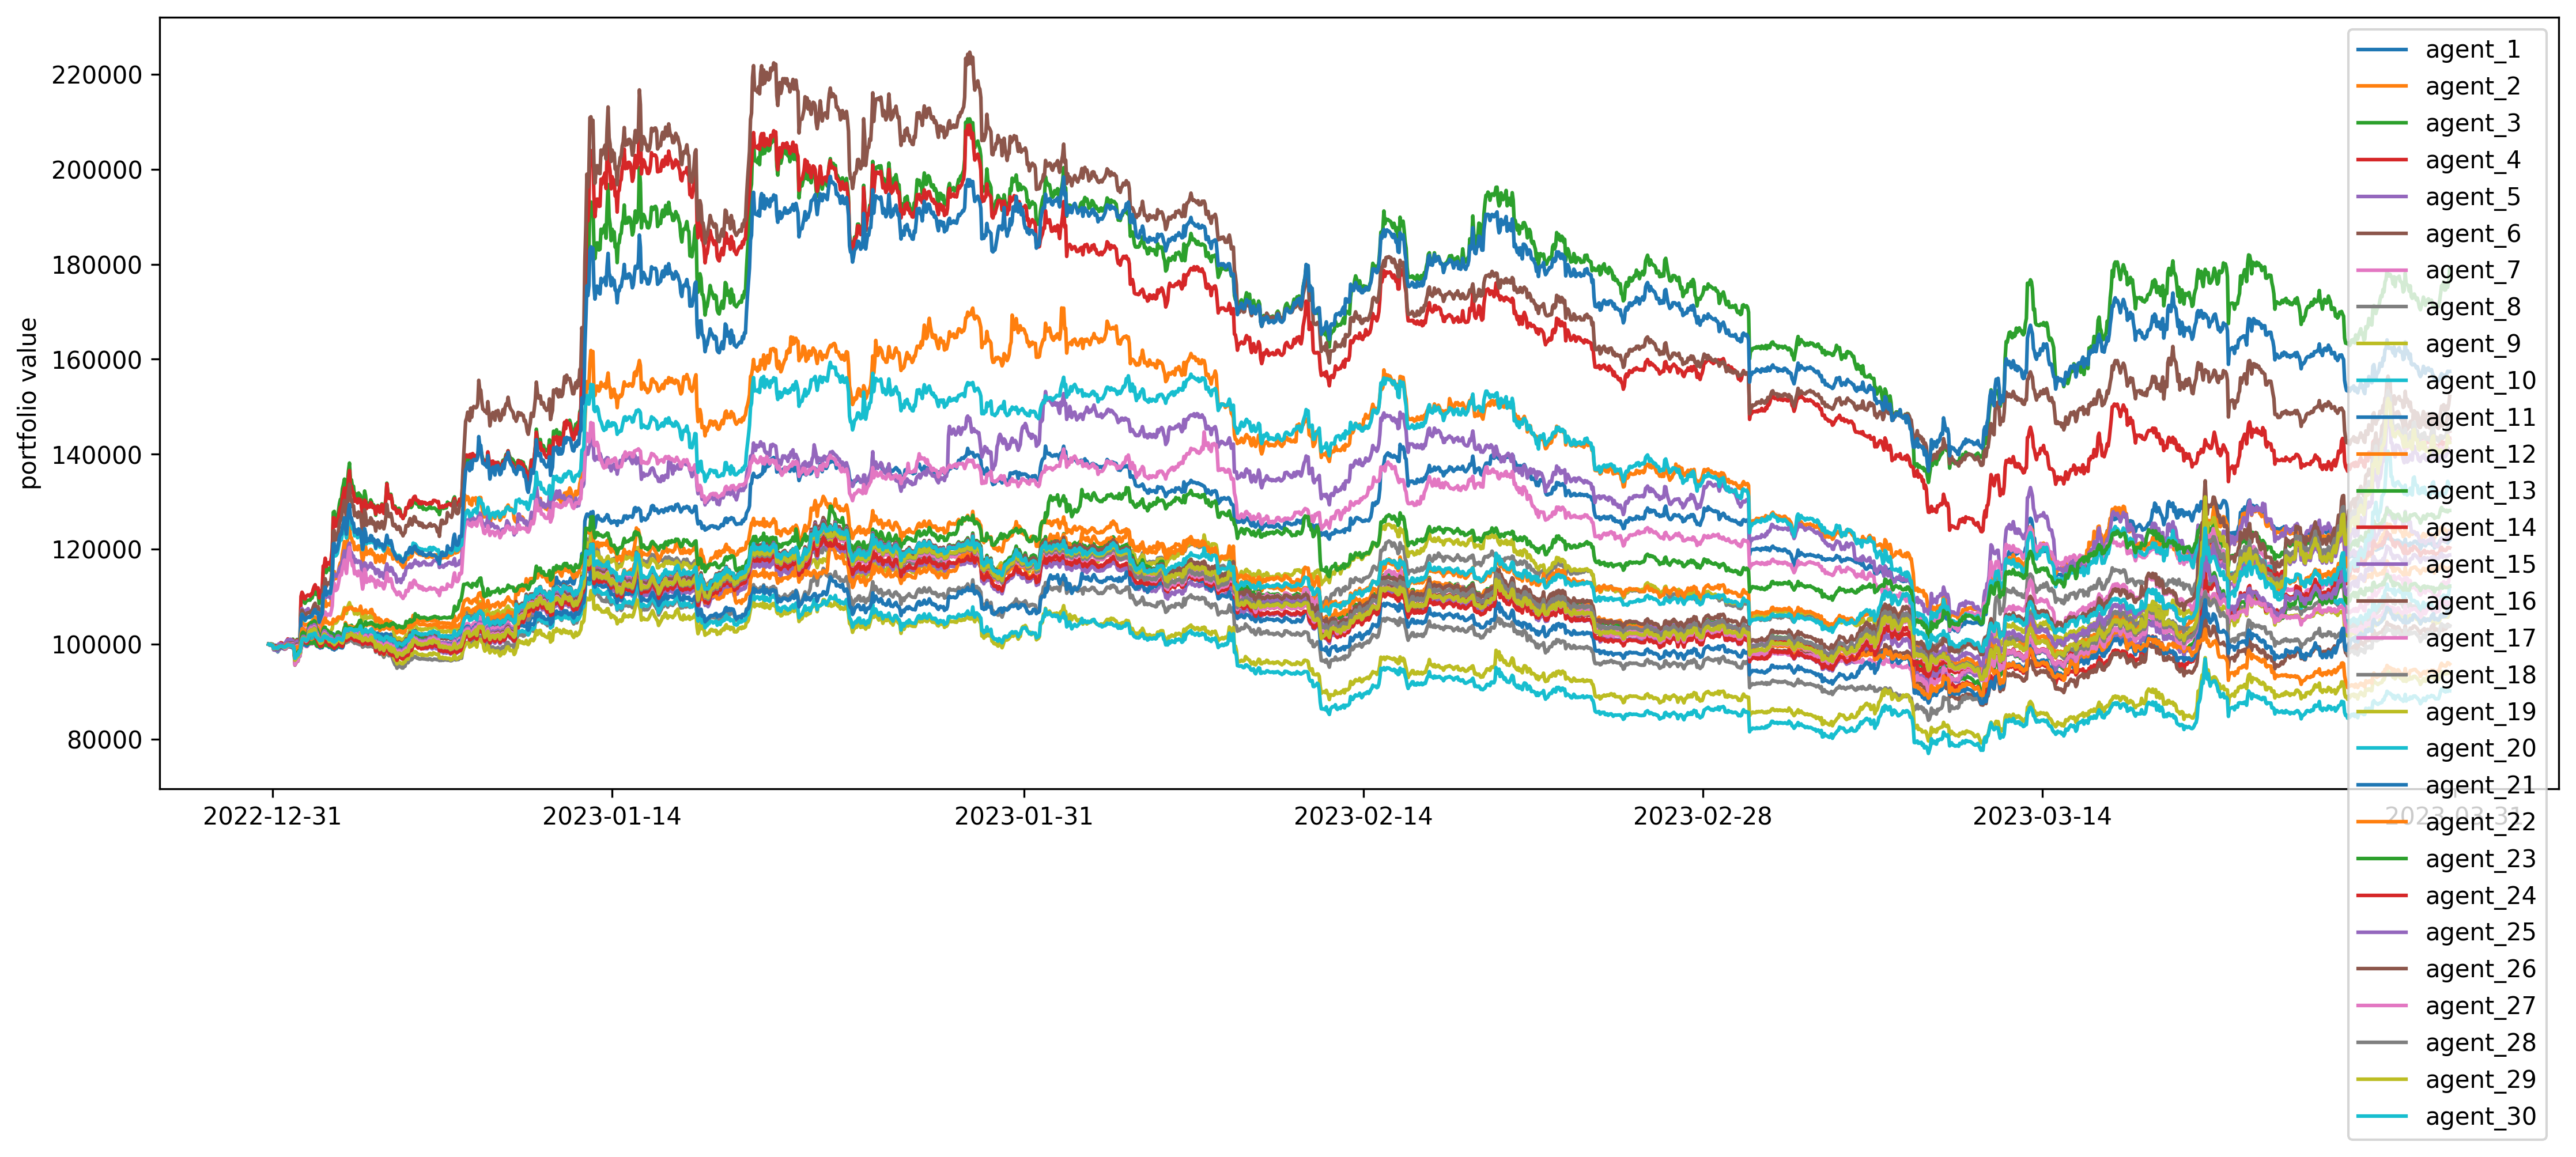

In [11]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["figure.dpi"] = 300
plt.figure()

x = df_account_value_ppo["timestamp"]
x = pd.to_datetime(x)
s = 1
for i in final:
    plt.plot(x,i,label=f'agent_{s}')
    s+=1
plt.ylabel("portfolio value")
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig("../../plot/test_plot/ppo_hourly_stack_frame/stack_5_hour_test_default_ppo_act_0.1_seed_42_new_reward.png", dpi=300)
plt.show()

In [12]:
df = pd.DataFrame(data = x)
s = 1
for i in final:
    df[f"round_{s}"] = i
    s += 1
df.to_csv("stack_5_hourly_test_default_ppo_act_0.1_seed_42_new_reward.csv")